#**Graduation Project**
#**pneumonia detection using deep learning**
#**Steps**
**1.Import libraries**

**2.Load dataset from Kaggle**

**3.Explore the data (Understanding our data )**

**4.Setting Model Parameters**

**5.Data Augmentation**

**6.Get Data Files From Dirctories(Applying Data Augmentation to data in directory)**

**7.build Deepl learning model**

**8.model.summary**

**9.train the model Fitting the model**

**10.Calculating Accuracy (Accuracy visualization)**

**11.Generate a SavedModel**

**12.Convert the SavedModel to TFLite**


# **Import Libararis**

In [1]:
# General libraries
import os       # to work with directory
import numpy as np
import pandas as pd 
#import random
import cv2   #to resize the images
import matplotlib.pyplot as plt
#%matplotlib inline

# Deep learning libraries
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
#from keras.optimizers import 'Adam'
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# Setting seeds for reproducibility
#seed = 232
#np.random.seed(seed)
#tf.set_random_seed(seed)

# **Load dataset from Kaggle**

In [2]:
! mkdir ~/.kaggle                 # make directory 'file' named kaggle '~' means in root
from google.colab import files    # to get kaggle.json from local device   kaggle.json >has data from my kaggle acount to linke kaggle to kolab
files.upload() 

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohamedkhaled7","key":"21de955bc003f46ed722448f9c260f89"}'}

In [3]:
! cp kaggle.json ~/.kaggle/     #make copy of kaggle.json 'make sure kaggle.json without space between kaggle.json ' files and next to sample_data this copy of kaggle.json and pat it in root/kaggle =>file i c
! chmod 600 ~/.kaggle/kaggle.json     #for more security
! kaggle datasets download paultimothymooney/chest-xray-pneumonia     #get dataset with its name without https://www.kaggle.com/

100% 2.29G/2.29G [00:17<00:00, 223MB/s]
100% 2.29G/2.29G [00:17<00:00, 142MB/s]


In [4]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

# **Understanding our data**

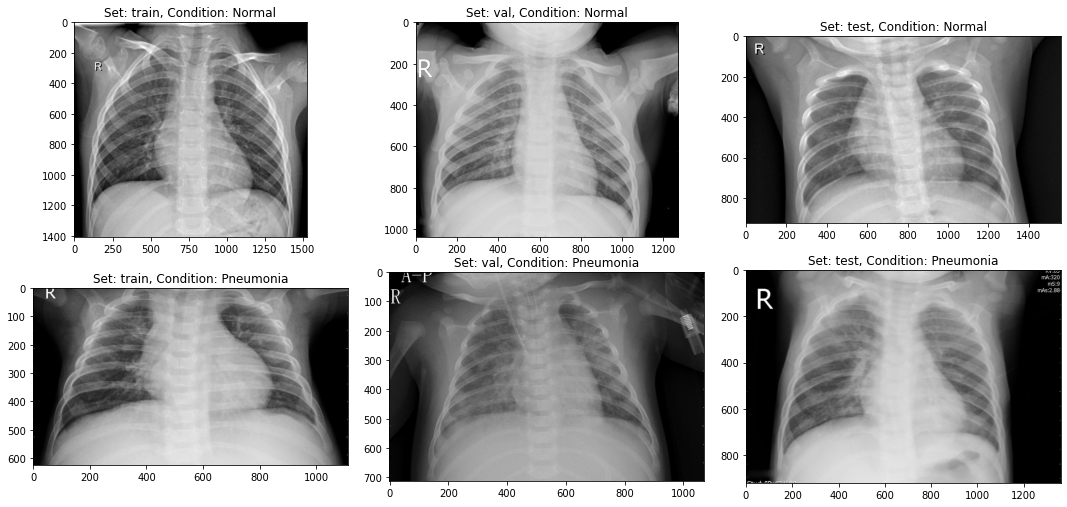

In [5]:
input_path = 'chest_xray/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [6]:
# Distribution of our datasets
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 1341, pneumonia images: 3875
Set: val, normal images: 8, pneumonia images: 8
Set: test, normal images: 234, pneumonia images: 390


# **Setting Model Parameters**

In [7]:
# Hyperparameters
img_dims = 150    # Our training data consists of images with width of 150 pixels and height of 150 pixels
batch_size = 32   # how many images model will traine every time or itration

# **Data Augmentation** 

In [8]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

# **Data Augmentation ( Flipping the image horizontally )**

In [9]:
# here we load data from the disk or memory by ImageDataGenerator and applying horizontal_flip on 
# when we work on model we take train_data_gen for train the model after applying horizontal_flip on 
# ImageDataGenerator rescale converting input values (images pixels) from 0 to 1 cnn prefer dealing with small inputs
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

#get images from memory with this features(batch_size,directory,shuffle='random or not',target_size='resize all images')
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=input_path+'train',
                                               shuffle=True,
                                               target_size=(img_dims,img_dims))

Found 5216 images belonging to 2 classes.


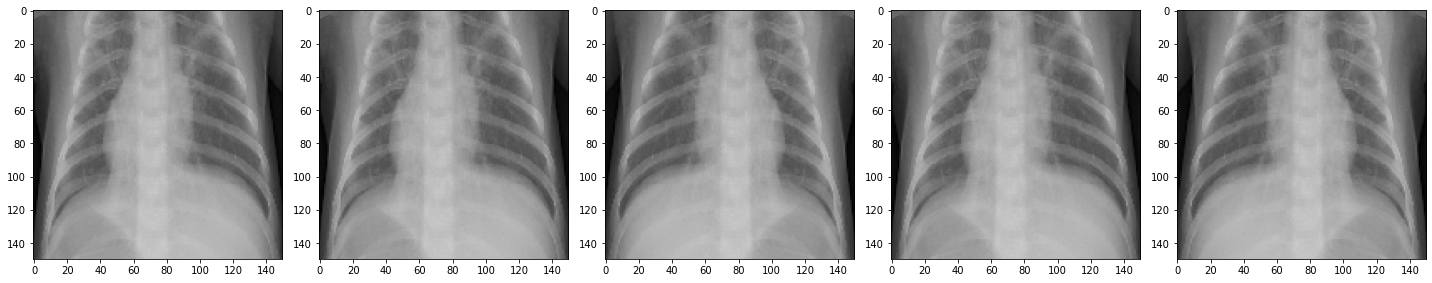

In [10]:
#train_data_gen[0][0][0] bacuse our image is colored whitch is mean every image is 3D matrix (widht,height,Depth(color))
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

# **Data Augmentation ( Rotating the image)**

In [11]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)
#get images from memory with this features(batch_size,directory,shuffle='random or not',target_size='resize all images')
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=input_path+'train',
                                               shuffle=True,
                                               target_size=(img_dims,img_dims))

Found 5216 images belonging to 2 classes.


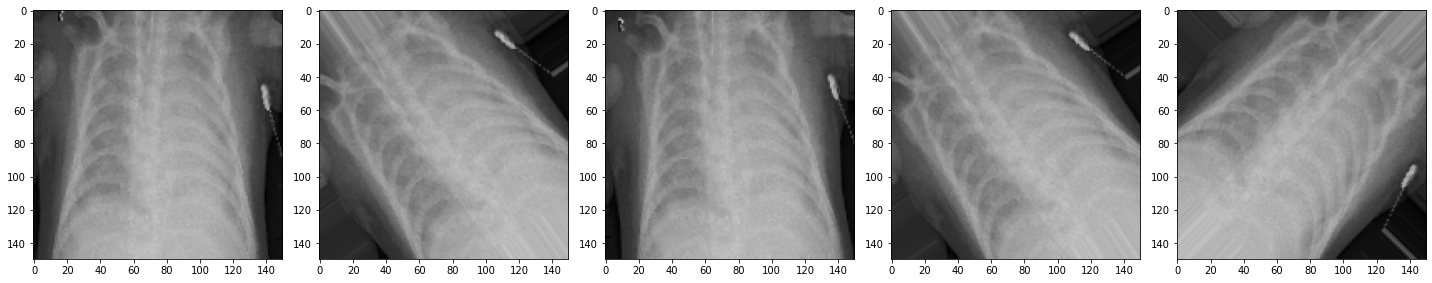

In [12]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

# **Data Augmentation (Applying Zoom)**

In [13]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)
#get images from memory with this features(batch_size,directory,shuffle='random or not',target_size='resize all images')
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=input_path+'train',
                                               shuffle=True,
                                               target_size=(img_dims,img_dims))

Found 5216 images belonging to 2 classes.


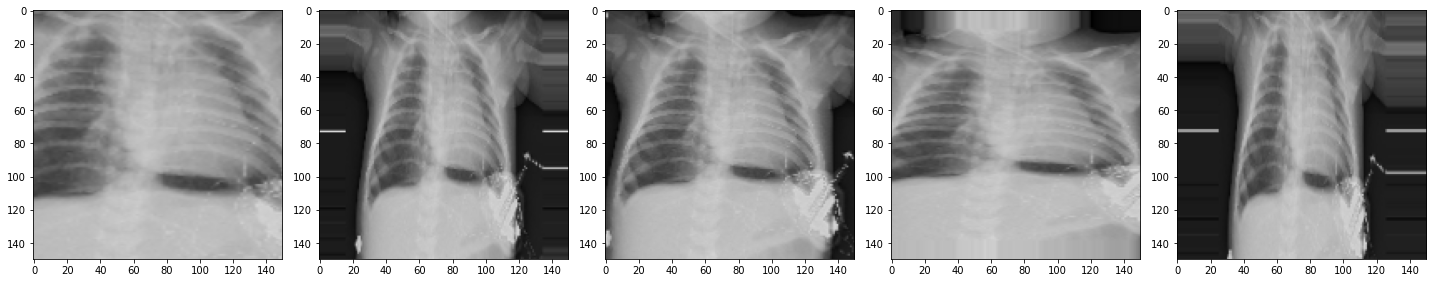

In [14]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

# **Putting it all together (Data Augmentation)**

In [15]:
# Data generation objects
image_gen_train = ImageDataGenerator( #ImageDataGenerator=> read images in folders with this and applay this propertis to them
rescale=1./255,
rotation_range=45,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest') 


# This is fed to the network in the specified batch sizes and image dimensions
train_gen = image_gen_train.flow_from_directory(
directory=input_path+'train', 
target_size=(img_dims, img_dims), 
batch_size=batch_size, 
class_mode='binary', 
shuffle=True)



Found 5216 images belonging to 2 classes.


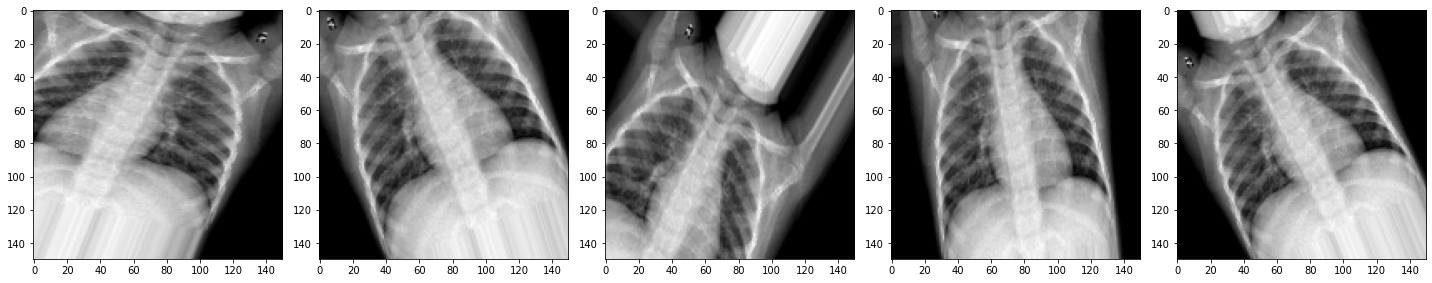

In [16]:
augmented_images = [train_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

# **Get Data Files From Dirctories**

In [17]:
def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_val_datagen = ImageDataGenerator(rescale=1./255)
    #Creating Validation Data generator
    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [18]:
# Getting the data
train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# **Define the model**

In [19]:
# Input layer
inputs = Input(shape=(img_dims, img_dims, 3))


# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs) #Conv2D =>CNN
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x) #sigmoid output is 0 or 1 

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max') #learning rate 
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

# **model.summary**

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 separable_conv2d (Separable  (None, 75, 75, 32)       688       
 Conv2D)                                                         
                                                                 
 separable_conv2d_1 (Separab  (None, 75, 75, 32)       1344  

# **Fitting the model**

In [21]:
epochs = 15

# Fitting the model
hist = model.fit(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

Epoch 1/15
163/163 [==============================] - 106s 571ms/step - loss: 0.3731 - accuracy: 0.8326 - val_loss: 0.7719 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/15
163/163 [==============================] - 95s 582ms/step - loss: 0.2704 - accuracy: 0.8892 - val_loss: 1.2731 - val_accuracy: 0.6201 - lr: 0.0010
Epoch 3/15
163/163 [==============================] - 92s 563ms/step - loss: 0.2601 - accuracy: 0.8907 - val_loss: 1.9091 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/15
163/163 [==============================] - 98s 601ms/step - loss: 0.2229 - accuracy: 0.9212 - val_loss: 0.9404 - val_accuracy: 0.6283 - lr: 0.0010
Epoch 5/15
163/163 [==============================] - ETA: 0s - loss: 0.2190 - accuracy: 0.9153
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 93s 569ms/step - loss: 0.2190 - accuracy: 0.9153 - val_loss: 0.7724 - val_accuracy: 0.4951 - lr: 0.0010
Epoch 6/15
163/163 [============================

# **ACCURACY**

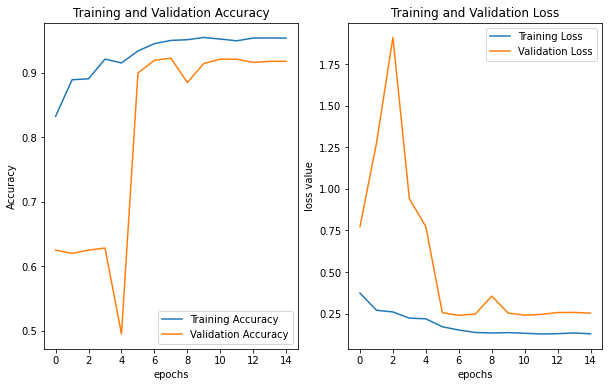

In [22]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel("epochs")
plt.ylabel("loss value")
plt.title('Training and Validation Loss')
plt.show()

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[190  44]
 [  9 381]]

TEST METRICS ----------------------
Accuracy: 91.50641025641025%
Precision: 89.64705882352942%
Recall: 97.6923076923077%
F1-score: 93.49693251533742

TRAIN METRIC ----------------------
Train acc: 95.38


# **Generate a SavedModel**

In [24]:
export_dir = 'saved_model/Pneumonia'
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/Pneumonia/assets


# **Convert the SavedModel to TFLite**

In [25]:
import pathlib

# Convert the model.
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [26]:
tflite_model_file=pathlib.Path("Pneumonia Detection (Chest_X-Ray).tflite")
tflite_model_file.write_bytes(tflite_model)

9269264

# **Download the TFLite model file**

In [27]:
try:
  from google.colab import files
  files.download(tflite_model_file)
except:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>